In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os

import re
from parser import parse_filename, natural_sort
import pandas as pd

from IPython import display
import time
import jax
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from config import * 

import sys, os
sys.path.append("../src")
from checkpoint import find_ckpt_filename, load_data
from matplotlib.offsetbox import AnchoredText

In [2]:
ref_file = '../analysis/refs/pnas2016.csv'
ref_df = pd.read_csv(ref_file, delimiter=r"\s+")
ref_df

,T,rs,etot,p,k,vtot,f,s
0,1200,1.34,-0.51592,269.00,NaN,-1.3083,NaN,NaN
1,1200,1.35,-0.51813,257.70,NaN,NaN,NaN,NaN
2,1200,1.36,-0.51980,243.10,NaN,NaN,NaN,NaN
3,1200,1.37,-0.52200,232.50,NaN,NaN,NaN,NaN
4,1200,1.38,-0.52560,234.10,NaN,NaN,NaN,NaN
5,1200,1.39,-0.52700,224.00,NaN,NaN,NaN,NaN
6,1200,1.40,-0.53010,218.50,NaN,NaN,NaN,NaN
7,1200,1.41,-0.53175,206.90,NaN,NaN,NaN,NaN
8,1200,1.42,-0.53353,198.50,NaN,NaN,NaN,NaN
9,1200,1.43,-0.53540,189.50,NaN,NaN,NaN,NaN


In [3]:
def get_gr(x, y): 
    batchsize, n, dim = x.shape[0], x.shape[1], x.shape[2]
    

    L = (4/3*np.pi*n)**(1/3)
        
    i,j = np.triu_indices(n, k=1)
    rij = (np.reshape(x, (-1, n, 1, dim)) - np.reshape(y, (-1, 1, n, dim)))[:,i,j]
    rij = rij - L*np.rint(rij/L)
    dist = np.linalg.norm(rij, axis=-1) # (batchsize, n*(n-1)/2)
   
    hist, bin_edges = np.histogram(dist.reshape(-1,), range=[0, L/2], bins=300)
    dr = bin_edges[1] - bin_edges[0]
    hist = hist*2/(n * batchsize)

    rmesh = np.arange(hist.shape[0])*dr
    
    h_id = 4/3*np.pi*n/(L**3)* ((rmesh+dr)**3 - rmesh**3 )
    return rmesh*rs, hist/h_id

../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-real-twist/n_54_dim_3_t_4_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_4_wh1_32_wh2_16_Nf_1_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_16_bs_8_accsteps_1/data.txt


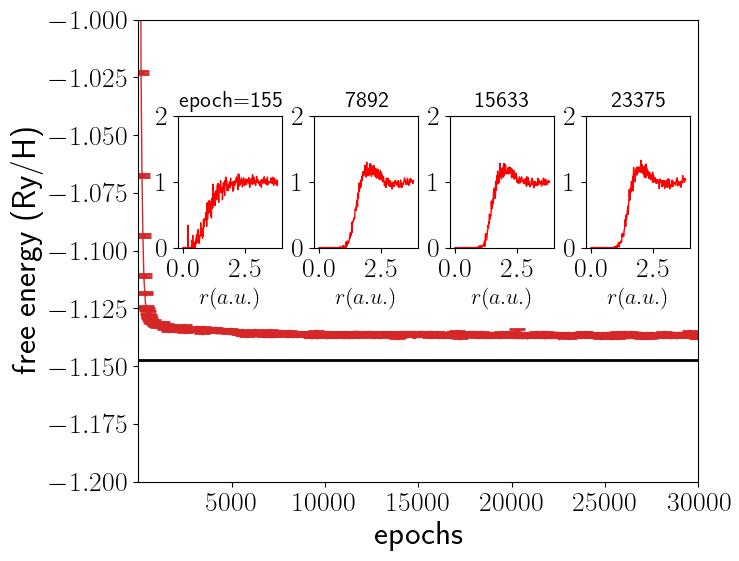

In [4]:
#f = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects/n_54_dim_3_rs_1.25_T_6000_fs_1_fd_4_fh1_32_fh2_16_wd_3_wh1_32_wh2_16_Nf_5_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_100_1000_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_1024_bs_8192_accsteps_1/data.txt'
#f = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-real-twist/n_54_dim_3_t_4_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_4_wh1_32_wh2_16_Nf_1_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_8_bs_8_accsteps_1/data.txt'
f = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-real-twist/n_54_dim_3_t_4_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_4_wh1_32_wh2_16_Nf_1_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_16_bs_8_accsteps_1/data.txt'
#f = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-real-twist/n_32_dim_3_t_4_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_4_wh1_32_wh2_16_Nf_1_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_10_100_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_16_bs_8_accsteps_1/data.txt'

obs = 'f'
marker = 'o'
color = 'C3'

fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
if True:
    
    n, dim, rs, T, s, fd, fh1, fh2, wd, wh1, wh2, b, a, lr, decay, eta, maxnorm, Nf, clip, K, w, nk, t = parse_filename(f)

    print (f)
    df = pd.read_csv(f, delimiter=r"\s+")
    label = r'$n=%s,dim=%s,r_s=%s,T=%g,s=%s,fd=%s,fh_1=%s,fh_2=%s,wd=%s,wh_1=%s,wh_2=%s,Nf=%s,K=%s,b=%sx%s,lr=%s,decay=%s,eta=%s,nrm=%s,clip=%s, walkers=%s$'\
                %(n,dim,rs,T,s,fd,fh1,fh2,wd,wh1,wh2,Nf,K,b,a,lr,decay,eta,maxnorm,clip,w)
  
    Kp = 1.5*T/157887.66 # proton kinetic energy in Ry 
    ds = -jax.scipy.special.gammaln(n+1)/n + 1.5*(1+np.log(1836*rs**2/(4*np.pi)*T/157887.66))

    if obs == 'f':
        y = df[obs].values + Kp - ds*T/157887.66
        yerr = df['f_err'].values    
    elif obs == 'vtot':
        y = df['vpp'].values + df['vep'].values + df['vee'].values
        yerr = np.sqrt(df['vpp_err'].values**2 + df['vep_err'].values**2 + df['vee_err'].values**2)       
    elif obs == 'etot':
        y = df['e'].values + df['vpp'].values
        yerr = np.sqrt(df['e_err'].values**2 + df['vpp_err'].values**2)
    elif obs in ['acc_s', 'acc_x']:
        y = df[obs].values
        yerr = np.zeros_like(y)
    else:
        y, yerr = df[obs].values, df[obs+'_err'].values
        
    SKIP = 50
    ax.errorbar(df['epoch'].values[::SKIP], y[::SKIP], yerr=yerr[::SKIP],
                 marker=marker, color=color,markerfacecolor='none', 
                 markeredgewidth=2, ms=2, capsize=6, label=label)
    #plt.fill_between(df['epoch'].values, y-yerr, y+yerr , edgecolor='r',
    #                 facecolor='r',linewidth=2)
    
    #plt.xscale('log') 
    plt.xlim([1, 30000])
    plt.ylim([-1.2, -1.0])
    
    try:
        ref_value = ref_df.query('(T==%g) & (rs==%g)'%(T, rs))[obs].values[0]
        if obs in ['etot', 'k', 'vtot', 'f']: ref_value = 2*ref_value 
        plt.axhline(y=ref_value, color='k', lw=2, zorder=99)
                
    except KeyError or IndexError:
        print ('no ref data')
    
    path = os.path.dirname(f)
    ckpt_files = [os.path.join(path, f) for f in os.listdir(path) if ('pkl' in f)]
    ckpt_files = natural_sort(ckpt_files) 
    SKIP = int(np.ceil( len(ckpt_files) / 4 ))
           
    for offset, ckpt_file in enumerate(ckpt_files[::SKIP]):
        if ckpt_file is None: continue
        #print (ckpt_file)
        data = load_data(ckpt_file)
        epoch = int(re.search('epoch_([0-9]*).pkl', ckpt_file).group(1))
    
        s = data['s']
        
        n, dim = s.shape[-2], s.shape[-1]
        s = s.reshape(-1, n, dim)
        
        rmesh, gr = get_gr(s, s)
        left, bottom, width, height = [0.25+offset*0.17, 0.5, 0.13, 0.22]
        inset = fig.add_axes([left, bottom, width, height])
        inset.plot(rmesh, gr, 'r')
        inset.set_ylim([0, 2])
        if offset ==0:    
            plt.title(r'epoch=%g'%(epoch), fontsize=16)
        else:
            plt.title(r'%g'%(epoch), fontsize=16)
            
        #if offset ==0: inset.set_ylabel('$g(r)$', fontsize=16)
        inset.set_xlabel('$r(a.u.)$', fontsize=16)
             
        
ax.set_ylabel('free energy (Ry/H)')
ax.set_xlabel('epochs')
plt.subplots_adjust(left=0.2)
plt.savefig('epoch.pdf')

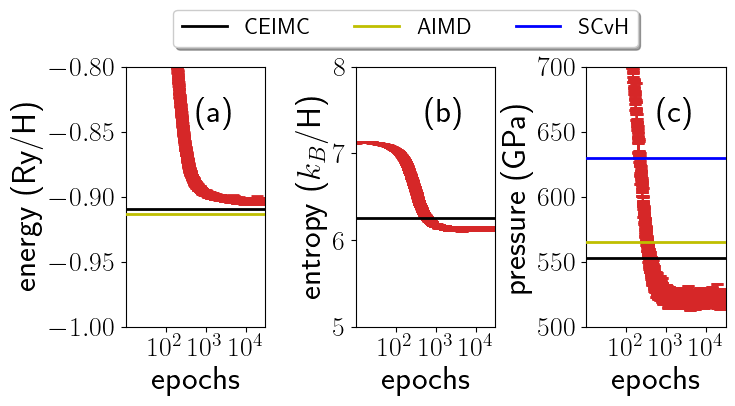

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(8, 4))

df = pd.read_csv(f, delimiter=r"\s+")
color = 'C3'

Kp = 1.5*T/157887.66 # proton kinetic energy in Ry 
ds = -jax.scipy.special.gammaln(n+1)/n + 1.5*(1+np.log(1836*rs**2/(4*np.pi)*T/157887.66))

#(a)
ax = ax1
y = df['e'].values + df['vpp'].values +  Kp 
yerr = np.sqrt(df['e_err'].values**2 + df['vpp_err'].values**2)
        
ax.errorbar(df['epoch'].values, y, yerr=yerr, color=color,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=4)
ax.set_ylabel('energy (Ry/H)')

ref_value = ref_df.query('(T==%g) & (rs==%g)'%(T, rs))['etot'].values[0] 
ref_value = 2*ref_value 
ax.axhline(y=ref_value, color='k', lw=2, zorder=99)
       
ref_value = -0.45675
ax.axhline(y=ref_value*2, color='y', lw=2, zorder=99)  
    
#ax.set_xscale('log')
#ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel('epochs')
#ax.set_xticks([2000, 4000])
ax.set_ylim([-1.0, -0.8])

at = AnchoredText("(a)",prop=dict(size=24), frameon=False,loc=1)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)  


#(b)
ax = ax2
y = df['s'].values + ds
yerr = df['s_err'].values
        
ax.errorbar(df['epoch'].values, y, yerr=yerr, color=color,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=4)
ax.set_ylabel('entropy ($k_B$/H)')

ref_value = ref_df.query('(T==%g) & (rs==%g)'%(T, rs))['s'].values[0]
ax.axhline(y=ref_value, color='k', lw=2, zorder=99)
        
#ax.set_xscale('log')
#ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.set_xticks([100, 1000, 10000])
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel('epochs')
ax.set_ylim([5, 8])

at = AnchoredText("(b)",prop=dict(size=24), frameon=False,loc=1)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)  

#(c)
ax = ax3 
L = (4/3*jnp.pi*n)**(1/3)
y = df['p'].values + (2*Kp)/(3*(L*rs)**3)*14710.513242194795*n
yerr = df[obs+'_err'].values       
    
ax.errorbar(df['epoch'].values[::SKIP], y[::SKIP], yerr=yerr[::SKIP], color=color,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=4)
ax.set_ylabel('pressure (GPa)')

ref_value = ref_df.query('(T==%g) & (rs==%g)'%(T, rs))['p'].values[0]
l1 = ax.axhline(y=ref_value, color='k', lw=2, zorder=99)
        
ref_value = 565.1
l2 = ax.axhline(y=ref_value, color='y', lw=2, zorder=99)    
    
ref_value = 629.6 # figure 4 of https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202
l3 = ax.axhline(y=ref_value, color='b', lw=2, zorder=99)    
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
#          fancybox=True, shadow=True, ncol=5)

labels = ['CEIMC', 'AIMD', 'SCvH']
fig.legend( [l1, l2, l3], labels, loc = 'upper center', 
            bbox_to_anchor=(0.5, 1.02), 
            ncol=3 , fancybox=True, shadow=True)

ax.set_xlim([10, 30000])
ax.set_xscale('log')
#ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_xticks([100, 1000, 10000])
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel('epochs')
ax.set_ylim([500, 700])

at = AnchoredText("(c)",prop=dict(size=24), frameon=False,loc=1)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at) 

plt.subplots_adjust(wspace=0.65, left=0.15, bottom=0.2, top=0.85)
plt.savefig('obs.pdf')

../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects/n_54_dim_3_rs_1.25_T_6000_fs_1_fd_4_fh1_32_fh2_16_wd_3_wh1_32_wh2_16_Nf_5_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_100_1000_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_1024_bs_8192_accsteps_1/epoch_003828.pkl
128 1024


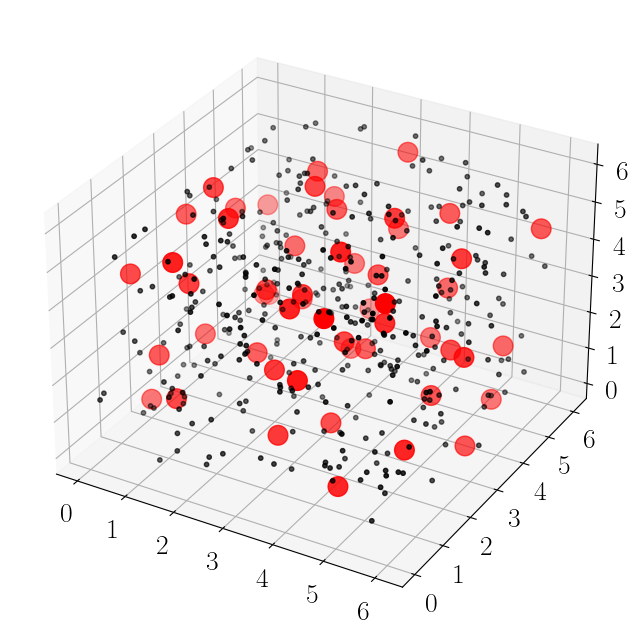

In [6]:

ckpt_file = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects/n_54_dim_3_rs_1.25_T_6000_fs_1_fd_4_fh1_32_fh2_16_wd_3_wh1_32_wh2_16_Nf_5_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_100_1000_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_1024_bs_8192_accsteps_1/epoch_003828.pkl'

print (ckpt_file)
data = load_data(ckpt_file)
    
s, x = data['s'], data['x']
n, dim = x.shape[-2], x.shape[-1]
s = s.reshape(-1, n, dim)
x = x.reshape(-1, n, dim)
W, B = s.shape[0], x.shape[0]

L = (4/3*np.pi*n)**(1/3)
s = s - L*np.floor(s/L)
x = x - L*np.floor(x/L)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(projection='3d')

print (W, B)
b = 0

ax.scatter(s[b, :, 0], s[b, :, 1], s[b, :, 2], marker='o', color='r', s=200)
ax.scatter(x[b*(B//W):(b+1)*(B//W), :n//2, 0], x[b*(B//W):(b+1)*(B//W), :n//2, 1], x[b*(B//W):(b+1)*(B//W), :n//2, 2], marker='o', color='k', s=10)
ax.scatter(x[b*(B//W):(b+1)*(B//W), n//2:, 0], x[b*(B//W):(b+1)*(B//W), n//2:, 1], x[b*(B//W):(b+1)*(B//W), n//2:, 2], marker='o', color='k', s=10)

FileNotFoundError: [Errno 2] No such file or directory: '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-gs-real/n_16_dim_3_rs_1.31_T_6000_fs_1_fd_2_fh1_16_fh2_16_wd_4_wh1_32_wh2_16_Nf_5_K_1_nk_19_Gmax_15_kappa_10_mctherm_10_mcsteps_10_50_mcwidth_0.02_0.04_lr_1_0.05_decay_0.001_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_1_bs_4096_accsteps_1/data.txt'

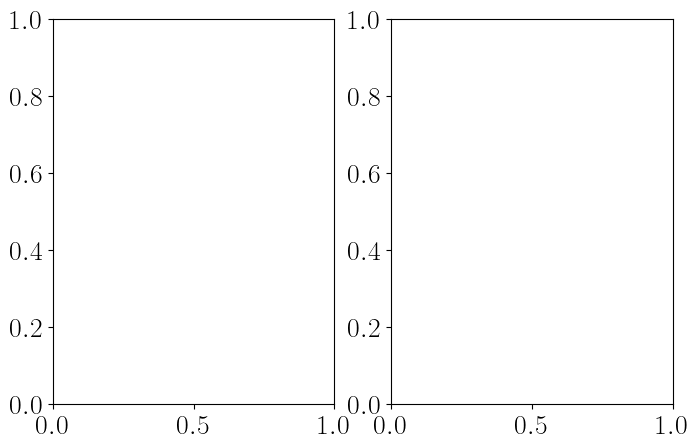

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(8, 5))

f1 = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-gs-real/n_16_dim_3_rs_1.31_T_6000_fs_1_fd_2_fh1_16_fh2_16_wd_4_wh1_32_wh2_16_Nf_5_K_1_nk_19_Gmax_15_kappa_10_mctherm_10_mcsteps_10_50_mcwidth_0.02_0.04_lr_1_0.05_decay_0.001_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_1_bs_4096_accsteps_1/data.txt'
f2 = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-gs-liquid-real/n_16_dim_3_rs_1.31_T_6000_fs_1_fd_2_fh1_16_fh2_16_wd_4_wh1_32_wh2_16_Nf_5_K_1_nk_19_Gmax_15_kappa_10_mctherm_10_mcsteps_10_50_mcwidth_0.02_0.04_lr_1_0.05_decay_0.001_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_1_bs_8192_accsteps_1/data.txt'

#f1 = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-gs-wanghan-bcc/n_16_dim_3_rs_1.31_T_6000_fs_1_fd_2_fh1_16_fh2_16_wd_4_wh1_32_wh2_16_Nf_1_K_4_nk_19_Gmax_15_kappa_10_mctherm_10_mcsteps_10_50_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_1_bs_2048_accsteps_1/data.txt'
#f2 = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-gs-wanghan/n_16_dim_3_rs_1.31_T_6000_fs_1_fd_2_fh1_16_fh2_16_wd_4_wh1_32_wh2_16_Nf_1_K_4_nk_19_Gmax_15_kappa_10_mctherm_10_mcsteps_10_50_mcwidth_0.02_0.04_lr_1_0.05_decay_0.001_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_1_bs_2048_accsteps_1/data.txt'


obs = 'etot'
marker = 'o'
color = 'C3'

def plot_subplot(f, ax):
    n, dim, rs, T, s, fd, fh1, fh2, wd, wh1, wh2, b, a, lr, decay, eta, maxnorm, Nf, clip, K, w, nk, t = parse_filename(f)

    df = pd.read_csv(f, delimiter=r"\s+")

    y = df['e'].values + df['vpp'].values
    yerr = np.sqrt(df['e_err'].values**2 + df['vpp_err'].values**2)
  
    SKIP = 10
    ax.errorbar(df['epoch'].values[::SKIP], y[::SKIP]/2, yerr=yerr[::SKIP]/2,
                 marker=marker, color=color,markerfacecolor='none', 
                 markeredgewidth=2, ms=2, capsize=4, ls='none')

    #plt.xscale('log') 
  
plot_subplot(f1, ax1)#solid
plot_subplot(f2, ax2)#liquid


ax1.axhline(y=-0.4878, color='k', lw = 2, label='ceperley')
ax1.axhline(y=-0.48875, color='y', lw = 2, label='sorella')
ax1.legend(loc='best')
#ax1.set_xlim([1, 4000])
ax1.set_ylim([-0.5, -0.47])
#ax1.set_xscale('log') 

#ax2.axhline(y=-0.4606, color='k', lw = 2, label='deep solid')
#ax2.legend(loc='best')
ax2.set_ylim([-0.47, -0.44])
ax2.set_yticks([-0.44, -0.46, -0.45, -0.47])

ax1.set_ylabel('energy (Ha/Atom)')
ax1.set_xlabel('epochs')
ax2.set_xlabel('epochs')

plt.subplots_adjust(left=0.15, wspace=0.4, bottom=0.15)    
    
plt.savefig('gs.pdf')

FileNotFoundError: [Errno 2] No such file or directory: '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-real-twist/n_54_dim_3_t_4_rs_1.2_T_5000_fs_1_fd_3_fh1_32_fh2_16_wd_3_wh1_32_wh2_16_Nf_1_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_8_bs_8_accsteps_1/data.txt'

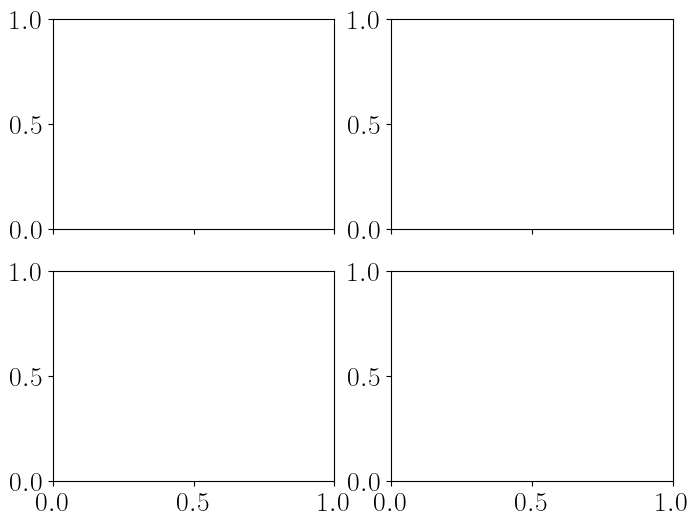

In [9]:
ax2.set_xscale('log')
ax2.set_xticks([100, 1000, 10000])#f = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf/n_54_dim_3_rs_1.2_T_5000_fs_1_fd_3_fh1_16_fh2_16_wd_3_wh1_16_wh2_16_Nf_5_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_1_1_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_256_bs_2048_accsteps_2/data.txt'

f = '../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-real-twist/n_54_dim_3_t_4_rs_1.2_T_5000_fs_1_fd_3_fh1_32_fh2_16_wd_3_wh1_32_wh2_16_Nf_1_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_8_bs_8_accsteps_1/data.txt'
n, dim, rs, T, s, fd, fh1, fh2, wd, wh1, wh2, b, a, lr, decay, eta, maxnorm, Nf, clip, K, w, nk, t = parse_filename(f)


fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(2, 2, sharex=True, figsize=(8, 6))

df = pd.read_csv(f, delimiter=r"\s+")
color = 'C3'

Kp = 1.5*T/157887.66 # proton kinetic energy in Ry 
          #plt.subplots_adjust(wspace=0.4)
#(a)
ax = ax1
y = df['e'].values + df['vpp'].values + Kp
yerr = np.sqrt(df['e_err'].values**2 + df['vpp_err'].values**2)
        
ax.errorbar(df['epoch'].values, y, yerr=yerr, color=color,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=8)
ax.set_ylabel('energy (Ry/H)')

ref_value = ref_df.query('(T==%g) & (rs==%g)'%(T, rs))['etot'].values[0]
ref_value = 2*ref_value 
ax.axhline(y=ref_value, color='k', lw=2, zorder=99)
       
#ax.set_xscale('log')
#ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_xticks([2000, 4000])
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.set_xlabel('epochs')
ax.set_xlim([1, 4000])
ax.set_ylim([-1.0, -0.7])

at = AnchoredText("(a)",prop=dict(size=24), frameon=False,loc=2)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)  


#(b)
ax = ax2
y = df['k'].values + Kp
yerr = df['k_err'].values
        
ax.errorbar(df['epoch'].values, y, yerr=yerr, color=color,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=8)
ax.set_ylabel('k (Ry/H)')

ref_value = ref_df.query('(T==%g) & (rs==%g)'%(T, rs))['k'].values[0]
ax.axhline(y=2*ref_value, color='k', lw=2, zorder=99)
        
#ax.set_xscale('log')
#ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.set_xticks([100, 1000, 10000])
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.set_xlabel('epochs')
ax.set_ylim([1, 3])


at = AnchoredText("(b)",prop=dict(size=24), frameon=False,loc=2)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)  

#(c)
ax = ax3 
y = df['vpp'].values + df['vep'].values + df['vee'].values
yerr = np.sqrt(df['vpp_err'].values**2 + df['vep_err'].values**2 + df['vee_err'].values**2)       
        
ax.errorbar(df['epoch'].values, y, yerr=yerr, color=color,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=8)
ax.set_ylabel('v (Ry/H)')

ref_value = ref_df.query('(T==%g) & (rs==%g)'%(T, rs))['vtot'].values[0]
ax.axhline(y=2*ref_value, color='k', lw=2, zorder=99)
          
#ax.set_xscale('log')
#ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.set_xticks([100, 1000, 10000])
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel('epochs')
ax.set_ylim([-3, -2])

at = AnchoredText("(c)",prop=dict(size=24), frameon=False,loc=2)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at) 


#(d)
ax = ax4
L = (4/3*jnp.pi*n)**(1/3)
y = df['p'].values + (2*Kp)/(3*(L*rs)**3)*14710.513242194795*n
yerr = df['p_err'].values
        
ax.errorbar(df['epoch'].values, y, yerr=yerr, color=color,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=8)
ax.set_ylabel('pressure (Gpa)')

ref_value = ref_df.query('(T==%g) & (rs==%g)'%(T, rs))['p'].values[0]
ax.axhline(y=ref_value, color='k', lw=2, zorder=99)
        
#ax.set_xscale('log')
#ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.set_xticks([100, 1000, 10000])
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xlabel('epochs')
ax.set_ylim([500, 800])

at = AnchoredText("(d)",prop=dict(size=24), frameon=False,loc=2)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)  

plt.subplots_adjust(wspace=0.6, left=0.15, bottom=0.2, hspace=0.15)
plt.savefig('obs2.pdf')

n: 16 epoch: 19738 s.shape: (1, 64, 16, 16, 3)
n: 32 epoch: 13243 s.shape: (8, 8, 16, 32, 3)
n: 54 epoch: 23375 s.shape: (4, 2, 16, 54, 3)


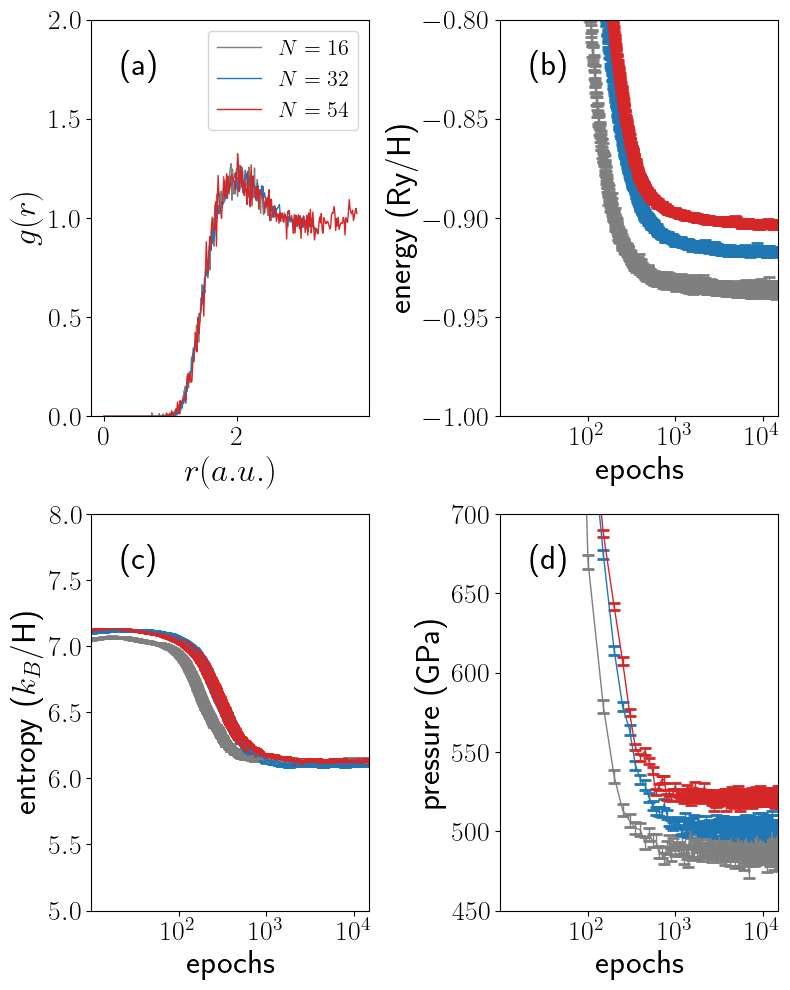

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10))

rs, T = 1.25, 6000
Kp = 1.5*T/157887.66 # proton kinetic energy in Ry

ns = [16, 32, 54]
paths = [
    "../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-real-twist/n_16_dim_3_t_4_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_4_wh1_32_wh2_16_Nf_1_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_10_100_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_16_bs_8_accsteps_1", 
    "../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-real-twist/n_32_dim_3_t_4_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_4_wh1_32_wh2_16_Nf_1_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_10_100_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_16_bs_8_accsteps_1", 
    "../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-real-twist/n_54_dim_3_t_4_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_4_wh1_32_wh2_16_Nf_1_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_16_bs_8_accsteps_1", 
]
colors = ["C7", "C0", "C3"]

for n, path, color in zip(ns, paths, colors):
    # (a) rdf
    ckpt_files = [os.path.join(path, f) for f in os.listdir(path) if "pkl" in f]
    ckpt_file = natural_sort(ckpt_files)[-1]
    epoch = int(re.search('epoch_([0-9]*).pkl', ckpt_file).group(1))
    
    data = load_data(ckpt_file)
    s = data['s']
    print("n:", n, "epoch:", epoch, "s.shape:", s.shape)
    n, dim = s.shape[-2], s.shape[-1]
    s = s.reshape(-1, n, dim)
    
    rmesh, gr = get_gr(s, s)
    ax = axes[0, 0]
    ax.plot(rmesh, gr, color=color, label="$N=%d$" % n)
    ax.set_ylim([0, 2])
    ax.set_xlabel('$r(a.u.)$')
    ax.set_ylabel('$g(r)$')
    ax.legend()
    
    f = os.path.join(path, "data.txt")
    df = pd.read_csv(f, delimiter=r"\s+")       
    
    SKIP = 50
    
    # (b) energy
    y = df['e'].values + df['vpp'].values + Kp 
    yerr = np.sqrt(df['e_err'].values**2 + df['vpp_err'].values**2)
    
    ax = axes[0, 1]
    ax.errorbar(df['epoch'].values, y, yerr=yerr, color=color,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=4, label="$N=%d$" % n)
    ax.set_xlabel('epochs')
    ax.set_ylabel('energy (Ry/H)')
    ax.set_xlim([10, 15000])
    ax.set_ylim([-1.0, -0.8])
    ax.set_xscale('log')
    ax.set_xticks([100, 1000, 10000])
    
    # (c) entropy
    ds = -jax.scipy.special.gammaln(n+1)/n + 1.5*(1+np.log(1836*rs**2/(4*np.pi)*T/157887.66))
    y = df['s'].values + ds
    yerr = df['s_err'].values
       
    ax = axes[1, 0]
    ax.errorbar(df['epoch'].values, y, yerr=yerr, color=color,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=4)
    ax.set_xlabel('epochs')
    ax.set_ylabel('entropy ($k_B$/H)')
    ax.set_xlim([10, 15000])
    ax.set_ylim([5, 8])
    ax.set_xscale('log')
    ax.set_xticks([100, 1000, 10000])
    
    # (d) pressure
    L = (4/3*np.pi*n)**(1/3)
    y = df['p'].values + (2*Kp)/(3*(L*rs)**3)*14710.513242194795*n
    yerr = df['p_err'].values
    
    ax = axes[1, 1]
    ax.errorbar(df['epoch'].values[::SKIP], y[::SKIP], yerr=yerr[::SKIP], color=color,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=4, label="$N=%d$" % n)
    ax.set_xlabel('epochs')
    ax.set_ylabel('pressure (GPa)')
    ax.set_xlim([10, 15000])
    ax.set_ylim([450, 700])
    ax.set_xscale('log')
    ax.set_xticks([100, 1000, 10000])
    #ax.legend()

panels = np.array([["(a)", "(b)"], 
                   ["(c)", "(d)"]])
for row in range(2):
    for col in range(2):
        at = AnchoredText(panels[row, col], prop=dict(size=24), frameon=False, loc=2)
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axes[row, col].add_artist(at)
    
plt.tight_layout()
plt.savefig('N_scaling.pdf')

twist: 1 epoch: 6426 s.shape: (1, 1, 1024, 16, 3)
twist: 2 epoch: 19115 s.shape: (4, 1, 128, 16, 3)
twist: 4 epoch: 19738 s.shape: (1, 64, 16, 16, 3)
twist: 6 epoch: 15948 s.shape: (4, 27, 6, 16, 3)


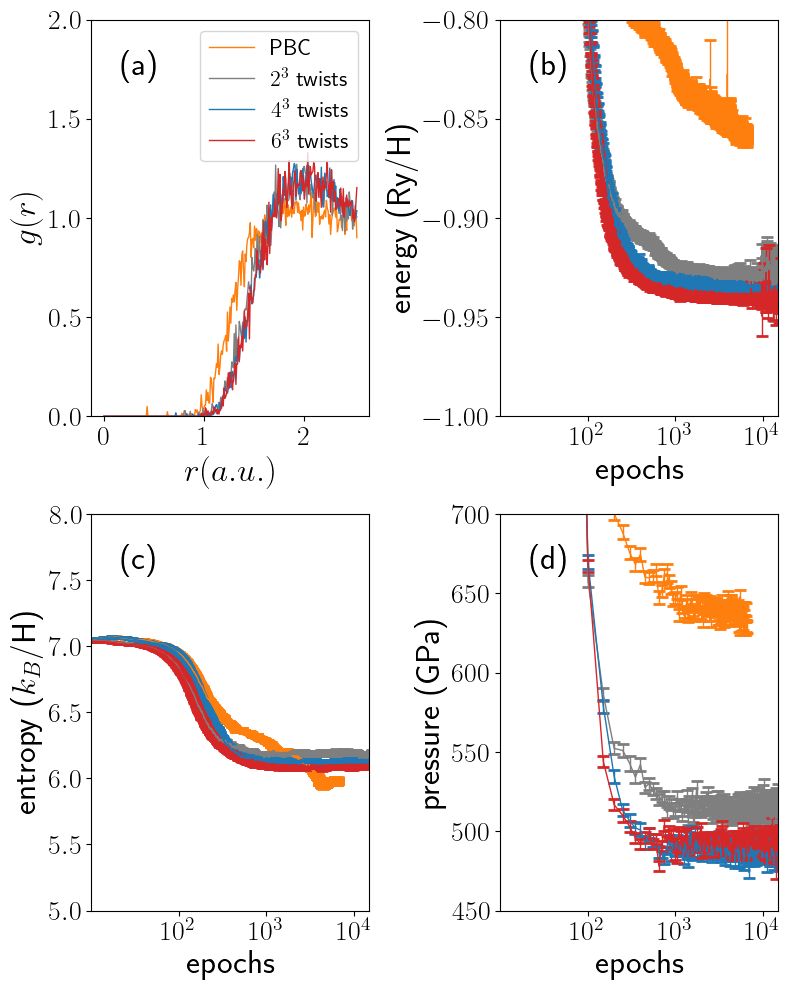

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10))

n, rs, T = 16, 1.25, 6000
Kp = 1.5*T/157887.66 # proton kinetic energy in Ry
ds = -jax.scipy.special.gammaln(n+1)/n + 1.5*(1+np.log(1836*rs**2/(4*np.pi)*T/157887.66))

twists = [1, 2, 4, 6]
paths = [
    "../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-real-twist/n_16_dim_3_t_1_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_4_wh1_32_wh2_16_Nf_1_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_10_100_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_1024_bs_8_accsteps_1",
    "../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-real-twist/n_16_dim_3_t_2_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_4_wh1_32_wh2_16_Nf_1_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_128_bs_8_accsteps_1", 
    "../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-real-twist/n_16_dim_3_t_4_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_4_wh1_32_wh2_16_Nf_1_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_10_100_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.05_ws_16_bs_8_accsteps_1", 
    "../data/ff35520-r-fixk0-backflow-tabc-w-feature-learnf-corrects-real-twist/n_16_dim_3_t_6_rs_1.25_T_6000_fs_1_fd_3_fh1_32_fh2_16_wd_4_wh1_32_wh2_16_Nf_1_K_1_nk_57_Gmax_15_kappa_10_mctherm_10_mcsteps_50_500_mcwidth_0.02_0.04_lr_0.05_0.05_decay_0.001_damping_0.001_0.001_norm_0.001_0.001_clip_5_alpha_0.1_ws_6_bs_8_accsteps_1", 
]
colors = ["C1", "C7", "C0", "C3"]

for t, path, color in zip(twists, paths, colors):
    # (a) rdf
    ckpt_files = [os.path.join(path, f) for f in os.listdir(path) if "pkl" in f]
    ckpt_file = natural_sort(ckpt_files)[-1]
    epoch = int(re.search('epoch_([0-9]*).pkl', ckpt_file).group(1))
    
    data = load_data(ckpt_file)
    s = data['s']
    print("twist:", t, "epoch:", epoch, "s.shape:", s.shape)
    n, dim = s.shape[-2], s.shape[-1]
    s = s.reshape(-1, n, dim)
    
    rmesh, gr = get_gr(s, s)
    ax = axes[0, 0]
    if t > 1:
        ax.plot(rmesh, gr, color=color, label="$%d^3$ twists" % t)
    else:
        ax.plot(rmesh, gr, color=color, label="PBC")
    ax.set_ylim([0, 2])
    ax.set_xlabel('$r(a.u.)$')
    ax.set_ylabel('$g(r)$')
    ax.legend(loc='upper right')
    
    f = os.path.join(path, "data.txt")
    df = pd.read_csv(f, delimiter=r"\s+")       
    
    SKIP = 50
    
    # (b) energy
    y = df['e'].values + df['vpp'].values + Kp 
    yerr = np.sqrt(df['e_err'].values**2 + df['vpp_err'].values**2)
    
    ax = axes[0, 1]
    ax.errorbar(df['epoch'].values, y, yerr=yerr, color=color,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=4, label="$N=%d$" % n)
    ax.set_xlabel('epochs')
    ax.set_ylabel('energy (Ry/H)')
    ax.set_xlim([10, 15000])
    ax.set_ylim([-1.0, -0.8])
    ax.set_xscale('log')
    ax.set_xticks([100, 1000, 10000])
    
    # (c) entropy
    y = df['s'].values + ds
    yerr = df['s_err'].values
       
    ax = axes[1, 0]
    ax.errorbar(df['epoch'].values, y, yerr=yerr, color=color,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=4)
    ax.set_xlabel('epochs')
    ax.set_ylabel('entropy ($k_B$/H)')
    ax.set_xlim([10, 15000])
    ax.set_ylim([5, 8])
    ax.set_xscale('log')
    ax.set_xticks([100, 1000, 10000])
    
    # (d) pressure
    L = (4/3*np.pi*n)**(1/3)
    y = df['p'].values + (2*Kp)/(3*(L*rs)**3)*14710.513242194795*n
    yerr = df['p_err'].values
    
    ax = axes[1, 1]
    ax.errorbar(df['epoch'].values[::SKIP], y[::SKIP], yerr=yerr[::SKIP], color=color,
            markerfacecolor='none', markeredgewidth=2, ms=2, capsize=4, label="$N=%d$" % n)
    ax.set_xlabel('epochs')
    ax.set_ylabel('pressure (GPa)')
    ax.set_xlim([10, 15000])
    ax.set_ylim([450, 700])
    ax.set_xscale('log')
    ax.set_xticks([100, 1000, 10000])
    #ax.legend()

panels = np.array([["(a)", "(b)"], 
                   ["(c)", "(d)"]])
for row in range(2):
    for col in range(2):
        at = AnchoredText(panels[row, col], prop=dict(size=24), frameon=False, loc=2)
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axes[row, col].add_artist(at)
    
plt.tight_layout()
plt.savefig('twist.pdf')